In [3]:
include("Julia_Implementation.jl")
using Random
import Pkg #Pkg is the package manager in Julia
using Distributions
using Plots
using LinearAlgebra
using ProgressMeter
Pkg.update()


LoadError: LoadError: ArgumentError: Package StatsFuns not found in current path.
- Run `import Pkg; Pkg.add("StatsFuns")` to install the StatsFuns package.
in expression starting at e:\Cambridge\Year 4\Fourth Year Projcet\IIB_Codes\Julia_Implementation.jl:1

In [5]:
import Pkg #Pkg is the package manager in Julia
Pkg.add("StatsFuns")

   Resolving package versions...
    Updating `C:\Users\Bill\.julia\environments\v1.9\Project.toml`
  [4c63d2b9] + StatsFuns v1.3.1
  No Changes to `C:\Users\Bill\.julia\environments\v1.9\Manifest.toml`


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


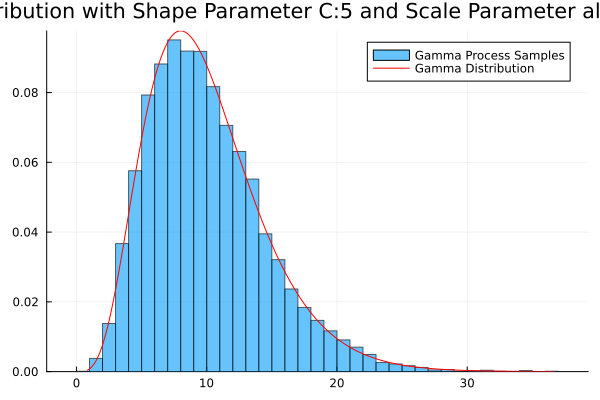

In [2]:
include("Julia_Implementation.jl")
using Random
import Pkg # Pkg is the package manager in Julia
using Distributions
using Plots
using LinearAlgebra
using ProgressMeter
N = 10000 # 样本数量
T = 1 # 模拟时间
beta = 0.5 # 逆比例参数
alpha = 1 / beta # 生成时的比例参数
C = 5 # 速率/形状参数
samples = Float64[]

@showprogress for i in 1:N
    samples_matrix, jump_time_matrix = Julia_Implementation.vectorized_particle_Gamma_generator(beta, C, T, 1, 100, 100)
    gamma_jumps = samples_matrix[1, :]
    gamma_jump_times = jump_time_matrix[1, :]
    sample = Julia_Implementation.integrate([1.0], gamma_jumps, gamma_jump_times)
    push!(samples, sample[1])
end

# 定义x的范围，以匹配samples的范围或更广
x = range(minimum(samples), stop=maximum(samples), length=1000)

p = histogram(samples, bins=50, normalize=true, alpha=0.6, label="Gamma Process Samples")
plot!(p, x, pdf.(Gamma(C, alpha), x), color=:red, label="Gamma Distribution")
title!(p, "Gamma Distribution with Shape Parameter C:$(C) and Scale Parameter alpha (1/beta):$(alpha)")
#legend!(:topright) # 如果需要图例，取消这行注释
display(p)


In [2]:
result = Julia_Implementation.myFunction(5)
println(result)

25


In [4]:
include("Julia_Implementation.jl")
using Random
using Pkg # Pkg is the package manager in Julia.
using Distributions
using Plots
using LinearAlgebra
using ProgressMeter

N = 10000 # 样本数量。
T = 10 # 模拟时间。
beta = 2 # 逆比例参数。
alpha = 1 / beta # 生成时的比例参数。
C = 2 # 速率/形状参数。
samples = Float64[]

@showprogress for i in 1:N
    samples_matrix, jump_time_matrix = Julia_Implementation.vectorized_particle_Gamma_generator(beta, C, T, 1, 100, c=100)
    gamma_jumps = samples_matrix[1, :]
    gamma_jump_times = jump_time_matrix[1, :]
    sample = Julia_Implementation.integrate([1.0], gamma_jumps, gamma_jump_times)
    push!(samples, sample[1]) # 注意这里使用sample[1]。
end

histogram(samples, bins=50, normalize=true, alpha=0.6, label="Gamma Process Samples") # 使用normalize=true。
x = range(minimum(samples), maximum(samples), length=1000) # 使用合适的长度来生成平滑的曲线。
plot!(x, pdf.(Gamma(C, alpha), x), color=:red, label="Gamma Distribution")
title!("Gamma Distribution with Shape Parameter C:$(C) and Scale Parameter alpha (1/beta):$(alpha)")
legend!(:topright)


UndefVarError: UndefVarError: `vectorized_particle_Gamma_generator` not defined

In [6]:
# 导入Test模块进行测试
using Test
# 假设Julia_Implementation.jl和本测试脚本在同一目录下，使用include来加载模块
include("Julia_Implementation.jl")
using .Julia_Implementation

# 接下来是测试函数的定义，这里假设你已经有了测试函数

# 检验概率正则化函数
function test_log_probs_to_normalised_probs()
    # 测试内容
end

# 检验加权和函数
function test_weighted_sum()
    # 测试内容
end

# 检验逆伽马分布转换函数
function test_inverted_gamma_to_mean_variance()
    # 测试内容
end

# 运行所有测试
function run_tests()
    test_log_probs_to_normalised_probs()
    test_weighted_sum()
    test_inverted_gamma_to_mean_variance()
    println("所有测试执行完毕！")
end

run_tests()


所有测试执行完毕！


In [3]:
using LinearAlgebra
x = I

UniformScaling{Bool}
true*I

In [3]:
include("JumpProcesses.jl")
using .JumpProcesses # 假设FinancialModels模块已经按前面的指示创建
using Distributions, LinearAlgebra, Random

# 参数初始化
beta_pcn = 1.0 # 预条件Crank-Nicolson算法的步长参数
n_iter = 300 # 迭代次数
theta0 = -1.0 # theta的初始猜测
beta0 = 5.0 # beta的初始猜测
C0 = 2.0 # C的初始猜测
num_particles = 1000

# 三个参数的步长
l_theta = 1.0
l_beta = 0.1
l_C = 2.0

# 真实参数值
true_theta = -1.0
kw = 1.0
kv = 0.001
true_sigmaw = 0.2
true_muw = 0.2
sigma_n = true_sigmaw * sqrt(kv)

# 模拟参数
true_beta = 5.0
true_C = 2.0
T = 30.0
N = 10 * T # 分辨率

# 定义Langevin动力学
A = zeros(2, 2)
A[1, 2] = 1.0
A[2, 2] = true_theta
h = [0.0, 1.0]

# 模拟
evaluation_points = range(0, T, length=N)
ngp = NormalGammaProcess(true_beta, true_C, T, true_muw, true_sigmaw) # 使用之前定义的结构体
samples, jumps, subordinator_jumps, jump_times = generateSamples(ngp, evaluation_points, all_data=true)

# 生成噪声观测数据
Noisy_samples = samples[1, :] .+ randn(length(samples[1, :])) .* sigma_n

# 下一步是基于这些数据进行参数估计或其他分析，这部分代码取决于具体的分析目标


TypeError: TypeError: in keyword argument length, expected Union{Nothing, Integer}, got a value of type Float64

In [1]:
using LinearAlgebra, Distributions, Random, Plots, ProgressMeter
include("Julia_Implementation.jl")
include("JumpProcesses.jl")
using .Julia_Implementation, .JumpProcesses

# 初始化参数
kw = 1.0
kv = 0.001
true_sigmaw2 = 0.2
true_muw = 0.2
true_sigmaw = sqrt(true_sigmaw2)
sigma_n = true_sigmaw * sqrt(kv)
num_particles = 1000

# 先验逆伽马参数
alphaws = fill(1e-10, num_particles)
betaws = fill(1e-10, num_particles)
accumulated_Es = zeros(num_particles)
accumulated_Fs = zeros(num_particles)

# 模拟参数
theta = -2.0
beta = 5.0
C = 10.0
T = 100.0
N = 1000

# 定义拉盖尔动力学
A = zeros(2, 2)
A[1, 2] = 1.0
A[2, 2] = theta
h = [0; 1]

# 模拟
evaluation_points = range(0, T, length=N)
gamma_process_generator = gamma_process(beta,C,T)
normal_gamma_generator = normal_gamma_process(beta, C, T, true_muw, true_sigmaw,gamma_process)
langevin = SDE(A, h, T, normal_gamma_generator)

# 生成噪声观测
SDE_samples, system_jumps, NVM_jumps, subordinator_jumps, jump_times = langevin.generate_samples(evaluation_points, true)
d1, d2 = size(SDE_samples)
Noisy_samples = SDE_samples[:, 1] .+ randn(length(SDE_samples)) .* sigma_n
# 绘制第一个变量
plot(evaluation_points, SDE_samples[:, 1], label="Variable 1", title="SDE Sample Paths", xlabel="Time", ylabel="Value")

# 在同一个图上添加第二个变量
plot!(evaluation_points, SDE_samples[:, 2], label="Variable 2")

# 显示图表
display(plot!())


# 粒子滤波器初始化
X0 = [zeros(3, 1) for _ in 1:num_particles]
C_prior = zeros(3, 3)
C_prior[end, end] = kw
g = [1 0 0]
R = [kv]

# 更多初始化...
# 根据你的实现细节，这部分代码需要调整

# 运行粒子滤波器
# 注意：以下是伪代码结构，需要根据你的具体实现调整
particles = [Particle(X0, C_prior) for _ in 1:num_particles]
weights = fill(1.0 / num_particles, num_particles)

# 你可能需要实现Particle类型和相关操作

# 循环遍历每个时间点
@progress for i in 1:N
    # 更新粒子、权重等
    # 根据observation更新粒子状态
end

# 绘制结果等
# 注意：Julia绘图使用Plots.jl，绘图代码需要相应调整


UndefVarError: UndefVarError: `gamma_process` not defined